In [1]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

# 1. 데이터 불러오기
iris = datasets.load_iris()
X = iris.data  # 모든 특성 사용
y = iris.target

# 학습용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# 2. 기본 모델 성능 확인 (하이퍼파라미터 튜닝 전)
model = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("기본 모델 정확도: ", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))


기본 모델 정확도:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [3]:
#GridSearchCV를 사용해서 하이퍼파라미터 튜닝을 진행했는데 GridSearchCV는 모델의 성능을 최적화하기 위해 하이퍼파라미터 조합을 탐색하는 기법입니다. C(오차 허용도) 와 gamma의 조합을 실험한후 가장 성능이 좋은 모델을 선택하는 방법을 사용했습니다.
# 3. 하이퍼파라미터 튜닝 (GridSearchCV 사용)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)
y_pred_grid = grid.predict(X_test)
print("하이퍼파라미터 튜닝 후 정확도: ", metrics.accuracy_score(y_test, y_pred_grid))
print(metrics.classification_report(y_test, y_pred_grid))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01

In [4]:
#특성 스케일링은 데이터의 각 특성의 범위를 일관성있게 맞추기 위한 전처리 기법입니다. 이는 주로 거리 기반 알고리즘이나 기울기 기반 학습 알고리즘에서 중요한 역할을 합니다.  .standardscaler는 각 특성의 평균을 0, 표준편차를 1로 맞추어 표준화하는 기법으로.
#svm같은 거리 기반 알고리즘에서는 특성의 스케일이 서로 다를 경우 학습이 제대로 이루어지지 않기 때문에, 적용해야 된다고 생각을했고 스케일이 다른 특성들 사이의 차이를 보정함으로써 모델의 성능을 개선할수 있습니다.
#단점으로는 원본 데이터의 의미를 왜곡할수 있기 때문에 , 데이터에 따라 적용이 신중해야한다는 점입니다.
# 4. 특성 스케일링 (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_scaled = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)
print("특성 스케일링 후 정확도: ", metrics.accuracy_score(y_test, y_pred_scaled))
print(metrics.classification_report(y_test, y_pred_scaled))

특성 스케일링 후 정확도:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [5]:
#특성선택은 모델의 성능에 기여하지 않거나 노이즈가 많은 특성을 제거하여 학습속도와 모델의 성능을 개선하는 기법입니다. SelectKBest는 각 특성의 점수를 계산하여 상위k개의 특성을 선택합니다.
#이 코드에서는 ANOVA F-검정을 사용해 각 특성이 타겟 변수와 얼마나 관련이 있는지를 계산하고, 상위 두개의 특성을 선택했습니다. 데이터가 고차원일수록 더 적은 특성으로 성능을 유지하거나 개선할 수 있습니다.
#단점으로는 지나치게 많은 특성을 제거하면 중요한 정보를 잃을수도 있는데 , 지금의 iris데이터는 4차원이기 때문에, 고차원 데이터에 비해 특성 선택이 크게 유의미하지 않을수 있습니다.
#하지만 더 복잡한 데이터셋 예를 들어 100개의 특성이 있는 데이터셋에서는 20~30개의 중요한 특성만 골라내는 것이 모델을 더 간결하고 빠르게 만듭니다.
# 5. 특성 선택 (SelectKBest 사용)
selector = SelectKBest(f_classif, k=2)  # 중요한 2개의 특성만 선택
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

model_selected = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
model_selected.fit(X_train_selected, y_train)
y_pred_selected = model_selected.predict(X_test_selected)
print("특성 선택 후 정확도: ", metrics.accuracy_score(y_test, y_pred_selected))
print(metrics.classification_report(y_test, y_pred_selected))


특성 선택 후 정확도:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [6]:
#PCA는 고차원의 데이터를 더 적은 차원으로 줄이는 기법으로, 데이터 내의 변동성을 최대한 보존하면서 차원을 축소합니다.
#여기서는 4차원 데이터를 2차원으로 줄여 시각화 할수 있도록 했습니다. 하지만 iris데이터는 차원이 낮고 데이터의 구조가 단순하기 때문에, 차원 축소가 큰 차이를 만들지 않을수 있습니다.
# 6. 차원 축소 (PCA 사용)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model_pca = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
print("차원 축소 후 정확도: ", metrics.accuracy_score(y_test, y_pred_pca))
print(metrics.classification_report(y_test, y_pred_pca))


차원 축소 후 정확도:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [7]:
#교차검증은 데이터를 여러번 나누어 학습과 테스트를 반복하여, 모델의 일반화 성능을 평가하는 방법입니다. 일반적인 훈련-테스트 분할에서는 한번 나누어서 평가하지만, 교차검증은 데이터를 여러 번 나누어 평가하기 때문에 더 신뢰할 수 있는 결과를 제공합니다.
#교차검증은 데이터분할, 반복 학습-검증, 성능평가 순서로 이루어지는데 데이터분할은 데이터를 여러 개의 서브셋으로 나눕니다. 일반적으로 k-fold 교차 검증이 많이 사용되며, 이 방법에서는 데이터를 k개의 폴드로 나눕니다.
#다음으로 k개의 폴드 중 한 폴드를 검증 데이터셋으로 사용하고, 나머지 k-1개의 폴드를 학습 데이터셋으로 사용하여 모델을 학습시킵니다. 이를 k번 반복하면서 매번 다른 폴드를 검증데이터셋으로 사용합니다.
#교차검증은 모델이 훈련데이터에 과도하게 적합하는 과적합문제를 데이터를 여러 번 나누어 테스트함으로써 모델이 훈련데이터의 특정 부분에 치우치지 않도록하는 장점이 존재하지만 iris데이터는 데이터셋이 충분히 작고, 한번의 분할로도 안정적인 성능이 나오기 때문에 교차검증을 생략하고 단순한 훈련-테스트 분할만으로도 충분할 수 있습니다.
# 7. 교차 검증 (Cross-Validation)
scores = cross_val_score(svm.SVC(kernel='rbf', C=1.0, gamma='scale'), X_train, y_train, cv=5)
print("교차 검증 후 정확도 평균: ", scores.mean())


교차 검증 후 정확도 평균:  0.95


In [8]:
#Bagging은 여러 모델을 학습시켜 예측 결과를 결합함으로써 모델 성능을 향상시키는 앙상블 기법중 하나입니다. 부트스트랩 샘플링 방식으로 여러 개의 하위 데이터셋을 만들어, 각각의 데이터셋에서 학습한 모델을 결합해 최종 예측을 수행합니다.
#부트스트랩 샘플링은 데이터를 복원추출하는 방법으로, 같은 데이터가 여러 번 샘플링 될수 있습니다. 즉, 하나의 서브셋에 동일한 데이터가 중복될수도있고, 어떤 데이터는 서브셋에 포함되지 않을수도 있습니다.
#Bagging은 불안전한 모델에 적용하거나 과적합을 방지하거나 데이터 노이즈가 있을 경우 유리하게 작용할수 있는데 iris데이터셋에서는 데이터의 단순성과 SVM 모델의 높은 성능 덕분에 bagging은 굳이 필요하지 않은 기법입니다.
#이 데이터셋은 샘플수가 적고 과적합의 위험이 낮아, SVM 하나만으로도 충분히 좋은 성능을 낼수 있습니다.
# 8. Bagging을 사용한 앙상블 모델
bagging_model = BaggingClassifier(estimator=svm.SVC(kernel='rbf', C=1.0, gamma='scale'), n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
print("Bagging 후 정확도: ", metrics.accuracy_score(y_test, y_pred_bagging))
print(metrics.classification_report(y_test, y_pred_bagging))


Bagging 후 정확도:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


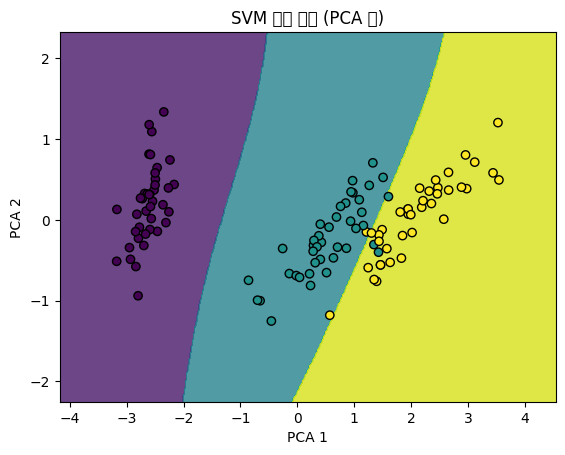

In [9]:

# 9. 결정 경계 시각화 (PCA 이후)
def plot_decision_boundary(X, y, model):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('SVM 결정 경계 (PCA 후)')
    plt.show()

# PCA 후 결정 경계 시각화
plot_decision_boundary(X_train_pca, y_train, model_pca)


Pca 를 사용해서 4차원의 데이터를 2차원으로 축소했기 때문에 이과정에서 분류에 필요한 중요한 정보가 손실되었을수 있습니다. 그래서 2차원 상에서 나타나는 결정 경계는 고차원 에서와 달리 완벽하게 분류 되지 않는 것처럼 보일수 있습니다.